In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,f1_score,recall_score,precision_score
from sklearn.metrics import roc_curve
import joblib
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from lightgbm import LGBMClassifier
from fancyimpute import IterativeImputer

In [2]:
# import the main file of the data
data=pd.read_csv("application_train.csv")

In [3]:
# storing the IDs of the appication for later use
SK_ID_CURR_train=data.SK_ID_CURR

In [4]:
# Dropping the IDs
data.drop("SK_ID_CURR",axis=1,inplace=True)

In [5]:
# Dropping the columns having more than 50% missing values
columns_drop=[i for i in data.columns if (sum(data[i].isna())/len(data)*100>50)]

In [6]:
# drops the column
data.drop(columns_drop,inplace=True,axis=1)

In [8]:
# columns which have 
data.columns[data.isna().sum()>0]

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE',
       'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

Median: 0.05
Mean: 0.05369499993495117


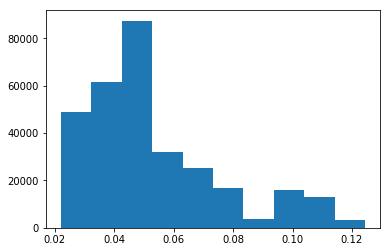

In [9]:
# Calculating the median and mean values for the ratio of amount annuity and amount credit column
print("Median:",(data[data.AMT_ANNUITY.notna()].AMT_ANNUITY/data[data.AMT_ANNUITY.notna()].AMT_CREDIT).median())
print("Mean:",(data[data.AMT_ANNUITY.notna()].AMT_ANNUITY/data[data.AMT_ANNUITY.notna()].AMT_CREDIT).mean())
plt.hist(data[data.AMT_ANNUITY.notna()].AMT_ANNUITY/data[data.AMT_ANNUITY.notna()].AMT_CREDIT);

In [10]:
# Replacing the missing values in amount annuity with product of amount credit median value that we got above
data.loc[data[data.AMT_ANNUITY.isna()].index,"AMT_ANNUITY"]=data.AMT_CREDIT*0.05

In [11]:
# The percentage of rows of Revolving columns which have Amount Credit equal to Amount Goods Price
len(data[(data.NAME_CONTRACT_TYPE=="Revolving loans") & (data.AMT_CREDIT==data.AMT_GOODS_PRICE)])/len(data[data.NAME_CONTRACT_TYPE=="Revolving loans"])

0.9793025718091465

In [12]:
# As in 97 % rows the amount credit is equal to amount goods price in revolving loans, we replace the missing values in 
# Amounts goods price with amount credit
data.loc[data[data.AMT_GOODS_PRICE.isna()].index,"AMT_GOODS_PRICE"]=data.loc[data[data.AMT_GOODS_PRICE.isna()].index,"AMT_CREDIT"]

In [13]:
# Filling the Name Type Suite with the mode value
data["NAME_TYPE_SUITE"].fillna("Unaccompanied",inplace=True,axis=0)

In [14]:
# Converting the days birth into positive years from negative days
data.DAYS_BIRTH=data.DAYS_BIRTH*-1/365

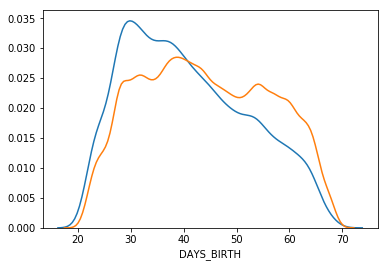

In [15]:
# KDE plot of days birth for target 0 and 1
sns.distplot(data[data.TARGET==1].DAYS_BIRTH,hist=False)
sns.distplot(data[data.TARGET==0].DAYS_BIRTH,hist=False)

In [16]:
# making bins for Days Birth
data['DAYS_BIRTH'] = pd.cut(data['DAYS_BIRTH'], bins = np.linspace(20, 70, num = 11))

In [17]:
# Filling the column with mode values
data.CNT_FAM_MEMBERS.fillna(value=2,inplace=True)

Mean 0.5143926741308463
Median 0.5659614260608526


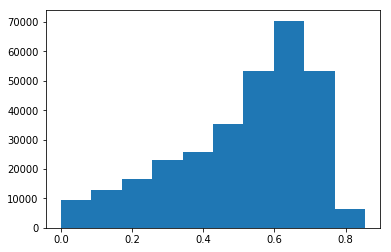

In [18]:
# Calculating the mean and median values for EXT_SOURCE2
print("Mean",data.EXT_SOURCE_2.mean())
print("Median",data.EXT_SOURCE_2.median())
plt.hist(data[data.EXT_SOURCE_2.notna()].EXT_SOURCE_2);

In [19]:
# Filling tthe EXT SOURCE 2 missing values with the median
impute_value_ext2=data.EXT_SOURCE_2.median()
data.EXT_SOURCE_2.fillna(impute_value_ext2,inplace=True)

Mean 0.5108529061800121
Median 0.5352762504724826


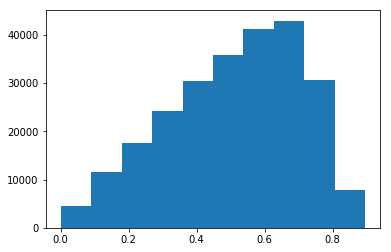

In [20]:
# Calculating the mean and median values for EXT_SOURCE3
print("Mean",data.EXT_SOURCE_3.mean())
print("Median",data.EXT_SOURCE_3.median())
plt.hist(data[data.EXT_SOURCE_3.notna()].EXT_SOURCE_3);

In [21]:
# Filling tthe EXT SOURCE 3 missing values with the median
impute_value_ext3=data.EXT_SOURCE_3.median()
data.EXT_SOURCE_3.fillna(impute_value_ext3,inplace=True)

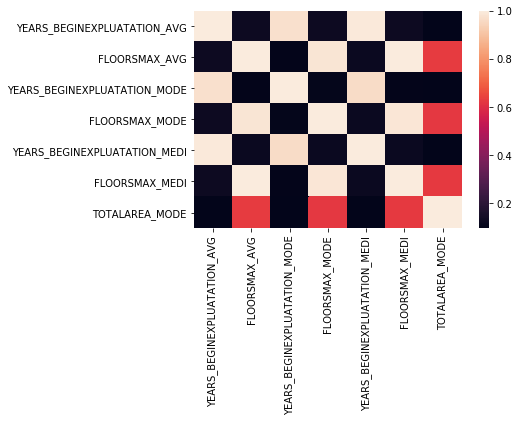

In [22]:
# plots a heatmap
sns.heatmap(data[['YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE',
       'EMERGENCYSTATE_MODE']].corr());

In [23]:
# dropping the columns which have high correlation as seen in the above heatmap
data.drop(['YEARS_BEGINEXPLUATATION_MODE','YEARS_BEGINEXPLUATATION_MEDI'],inplace=True,axis=1)

In [24]:
# drops the columns with high correlation
data.drop(['FLOORSMAX_MODE','FLOORSMAX_MEDI'],inplace=True,axis=1)

In [25]:
# filling the column with mode value
data["EMERGENCYSTATE_MODE"].fillna("No",inplace=True)

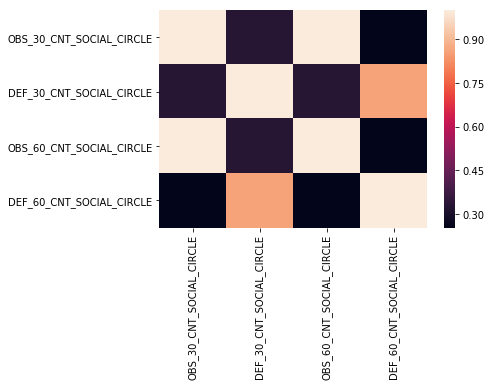

In [26]:
sns.heatmap(data[['OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE']].corr());

In [27]:
# drop the columns with multicollinearity as seen from above plot
data.drop(['OBS_60_CNT_SOCIAL_CIRCLE'],inplace=True,axis=1)

In [28]:
# Converting the negative days to positive year
data.DAYS_LAST_PHONE_CHANGE=data.DAYS_LAST_PHONE_CHANGE*-1/365

In [29]:
# Calculating the mean and median values
print("Mean:",data.DAYS_LAST_PHONE_CHANGE.mean())
print("Median:",data.DAYS_LAST_PHONE_CHANGE.median())

Mean: 2.6379692831018864
Median: 2.073972602739726


In [30]:
# Imputing with the help of the median value
impute_value_phone=data.DAYS_LAST_PHONE_CHANGE.median()
data.DAYS_LAST_PHONE_CHANGE.fillna(value=impute_value_phone,inplace=True)

In [31]:
# Replacing the anomaly data with na and creating a new dummy variable type column for that
data["DAYS_EMPLOYED_ANOMALY"]=(data.DAYS_EMPLOYED==365243).astype(int)
data.DAYS_EMPLOYED.replace({365243:np.nan},inplace=True)

In [32]:
# Converting the negative days to positive years
data.DAYS_EMPLOYED=data.DAYS_EMPLOYED*-1/365

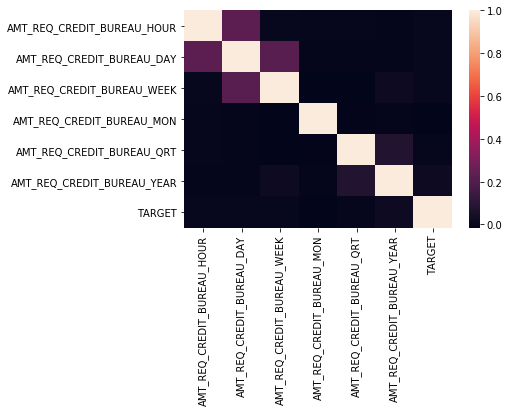

In [33]:
sns.heatmap(data[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR','TARGET']].corr());

In [34]:
# Converts negative days to positive years
data.DAYS_REGISTRATION=data.DAYS_REGISTRATION*-1/365
data.DAYS_ID_PUBLISH=data.DAYS_ID_PUBLISH*-1/365

In [39]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform both training and testing data
            data[col] = le.transform(data[col])
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [40]:
# make dummies for the data
data=pd.get_dummies(data)

In [ ]:
col_names=data.columns

In [47]:
# declares the MICE imputer
im=IterativeImputer()

In [48]:
# transforms our data
data=im.fit_transform(data)

In [49]:
# creates a dataframe
data=pd.DataFrame(data,columns=col_names)

In [ ]:
# data["SK_ID_CURR"]=SK_ID_CURR_train

In [51]:
# data.to_csv("data.csv",index=False)

In [3]:
# data=pd.read_csv("data.csv")

In [4]:
# data.drop("SK_ID_CURR",axis=1, inplace=True)

In [5]:
# Splits the data into train and test
X_train, X_test, y_train,y_test=train_test_split(data[data.columns[data.columns!="TARGET"]],data.TARGET,random_state=42,test_size=.3)

In [6]:
# Function to plot ROC_AUC_curve

def ROC_AUC_curve(model,model_name="Model"):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(8,4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

# MODELING

## Light GBM

### Base Model

In [7]:
lgb=LGBMClassifier(random_state=42)

In [7]:
# Fits the lgb model on train dataset
lgb.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [8]:
# ROC AUC score on train data
roc_auc_score(y_train,y_score=lgb.predict_proba(np.array(X_train))[:,1])

0.8030268075104705

In [9]:
# ROC AUC on test data
roc_auc_score(y_test,y_score=lgb.predict_proba(np.array(X_test))[:,1])

0.7605175708233542

In [10]:
print(classification_report(y_test,y_pred=lgb.predict(np.array(X_test))))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.52      0.02      0.04      7413

   micro avg       0.92      0.92      0.92     92254
   macro avg       0.72      0.51      0.50     92254
weighted avg       0.89      0.92      0.88     92254



### Tuned Model

In [9]:
lgb=LGBMClassifier(random_state=42)

In [ ]:
# Running on best model

In [11]:
lgb=LGBMClassifier(random_state=42,n_estimators=10000, reg_lambda=0.8,reg_alpha=1,learning_rate=.02)

In [13]:
lgb.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=42, reg_alpha=1, reg_lambda=0.8, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.779


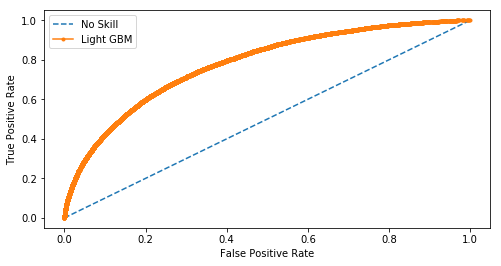

In [14]:
ROC_AUC_curve(model=lgb,model_name="Light GBM")

In [15]:
print("Training Accuracy Score:",accuracy_score(y_train,y_pred=lgb.predict(X_train)))
print("Testing Accuracy Score:",accuracy_score(y_test,y_pred=lgb.predict(X_test)))

Training Accuracy Score: 0.950905197043534
Testing Accuracy Score: 0.9207947622867301


In [16]:
print("Testing Report")
print(classification_report(y_test,y_pred=lgb.predict(X_test)))

Testing Report
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.58      0.05      0.09      7413

   micro avg       0.92      0.92      0.92     92254
   macro avg       0.75      0.52      0.53     92254
weighted avg       0.90      0.92      0.89     92254



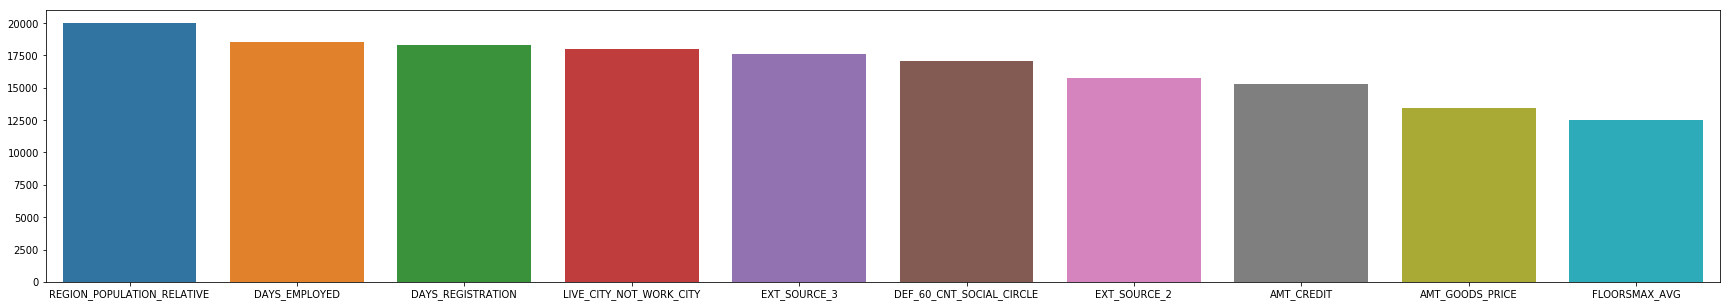

In [21]:
plt.figure(figsize=(30,5))
feature_importance_rm=OrderedDict(sorted(zip(data.columns,lgb.feature_importances_),reverse=True,key=lambda x:x[1]))
sns.barplot(list(feature_importance_rm.keys())[:10],list(feature_importance_rm.values())[:10]);

## Logistic Regression

### Base Model

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
# Scaler scales the data using standard deviation
scaler=StandardScaler()

In [17]:
# transforming the train data
X_train=scaler.fit_transform(X_train)

In [18]:
# transforming the test data
X_test=scaler.transform(X_test)

In [19]:
from sklearn.linear_model import LogisticRegression

In [21]:
lr=LogisticRegression(random_state=42)

In [22]:
# Fitting logistic regression 
lr.fit(X_train,y_train)

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.746


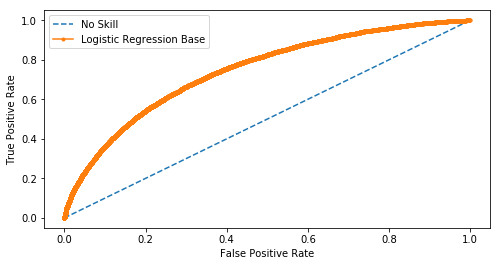

In [55]:
ROC_AUC_curve(model=lr,model_name="Logistic Regression Base")

In [53]:
print("Training Accuracy Score:",accuracy_score(y_train,y_pred=lr.predict(X_train)))
print("Testing Accuracy Score:",accuracy_score(y_test,y_pred=lr.predict(X_test)))

Training Accuracy Score: 0.9192174935077605
Testing Accuracy Score: 0.9196999588093742


In [52]:
print("Training Report")
print(classification_report(y_train,y_pred=lr.predict(X_train)))
print("Testing Report")
print(classification_report(y_test,y_pred=lr.predict(X_test)))

Training Report
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    197845
         1.0       0.53      0.01      0.02     17412

   micro avg       0.92      0.92      0.92    215257
   macro avg       0.72      0.51      0.49    215257
weighted avg       0.89      0.92      0.88    215257

Testing Report
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.51      0.01      0.03      7413

   micro avg       0.92      0.92      0.92     92254
   macro avg       0.72      0.51      0.49     92254
weighted avg       0.89      0.92      0.88     92254



### Tuned Model

In [34]:
param_grid_lr={'penalty':['l1','l2'],'class_weight':[{1:1,0:1},{1:5,0:1},{1:11,0:1}],'C':[.001,.1,1,.01]}

In [35]:
lr_grid_search=GridSearchCV(cv=6,estimator=lr,scoring="recall",n_jobs=-1,verbose=1,param_grid=param_grid_lr)

In [36]:
lr_grid_search.fit(X_train,y_train)

Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 50.2min
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "ti

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 11}], 'C': [0.001, 0.1, 1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [105]:
#joblib.dump(lr_grid_search.best_estimator_,"logistic_regression_tuned.sav")

['logistic_regression_tuned.sav']

In [107]:
#lr_grid_search=joblib.load("logistic_regression_tuned.sav")

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.742


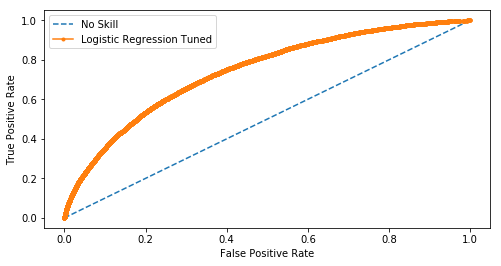

In [108]:
ROC_AUC_curve(model=lr_grid_search,model_name="Logistic Regression Tuned")

In [109]:
print("Training Accuracy Score:",accuracy_score(y_train,y_pred=lr_grid_search.predict(X_train)))
print("Testing Accuracy Score:",accuracy_score(y_test,y_pred=lr_grid_search.predict(X_test)))

Training Accuracy Score: 0.6921726122727716
Testing Accuracy Score: 0.6909944284258677


In [110]:
print("Training Report")
print(classification_report(y_train,y_pred=lr_grid_search.predict(X_train)))
print("Testing Report")
print(classification_report(y_test,y_pred=lr_grid_search.predict(X_test)))

Training Report
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.81    197845
         1.0       0.16      0.66      0.26     17412

   micro avg       0.69      0.69      0.69    215257
   macro avg       0.56      0.68      0.53    215257
weighted avg       0.89      0.69      0.76    215257

Testing Report
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.81     84841
         1.0       0.16      0.66      0.26      7413

   micro avg       0.69      0.69      0.69     92254
   macro avg       0.56      0.68      0.53     92254
weighted avg       0.89      0.69      0.76     92254



In [117]:
lr_coeff=sorted(zip(data.columns,lr_grid_search.coef_[0]),reverse=True,key=lambda x:x[1])

In [118]:
# Top 10 important variables as given by LR classifier
lr_coeff[:10]

[('REGION_RATING_CLIENT', 0.08332198173923872),
 ('AMT_CREDIT', 0.07605982071454674),
 ('NAME_EDUCATION_TYPE_Lower secondary', 0.07445527108116658),
 ('FLAG_DOCUMENT_2', 0.0670548968992675),
 ('OBS_30_CNT_SOCIAL_CIRCLE', 0.04465116823351332),
 ('LIVE_REGION_NOT_WORK_REGION', 0.04386619041900539),
 ('CODE_GENDER_F', 0.03920000375958995),
 ('DAYS_BIRTH_(25.0, 30.0]', 0.033501576721455886),
 ('DAYS_BIRTH_(30.0, 35.0]', 0.031842692796370885),
 ('DEF_30_CNT_SOCIAL_CIRCLE', 0.030676931141811508)]

## Random Forest

### Base Model

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
rm=RandomForestClassifier(random_state=42)

In [64]:
rm.fit(X_train,y_train)

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.639


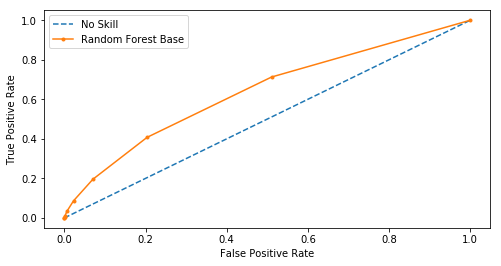

In [68]:
ROC_AUC_curve(model=rm,model_name="Random Forest Base")

In [69]:
print("Training Accuracy Score:",accuracy_score(y_train,y_pred=rm.predict(X_train)))
print("Testing Accuracy Score:",accuracy_score(y_test,y_pred=rm.predict(X_test)))

Training Accuracy Score: 0.9851294034572627
Testing Accuracy Score: 0.9189737030372667


In [70]:
print("Training Report")
print(classification_report(y_train,y_pred=rm.predict(X_train)))
print("Testing Report")
print(classification_report(y_test,y_pred=rm.predict(X_test)))

Training Report
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    197845
         1.0       1.00      0.82      0.90     17412

   micro avg       0.99      0.99      0.99    215257
   macro avg       0.99      0.91      0.95    215257
weighted avg       0.99      0.99      0.98    215257

Testing Report
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.36      0.01      0.02      7413

   micro avg       0.92      0.92      0.92     92254
   macro avg       0.64      0.50      0.49     92254
weighted avg       0.88      0.92      0.88     92254



### Tuned Model

In [75]:
param_grid_rm={'max_depth':[25,50],'class_weight':[{1:1,0:1},{1:5,0:1},{1:11,0:1},{1:17,0:1}],
               'min_samples_split':[100,50,25],'n_estimators':[100,500]}

In [76]:
rm_grid_search=GridSearchCV(cv=6,estimator=rm,scoring="recall",n_jobs=-1,verbose=1,param_grid=param_grid_rm)

In [77]:
rm_grid_search.fit(X_train,y_train)

Fitting 6 folds for each of 48 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 239.8min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 353.1min finished


GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 500], 'min_samples_split': [100, 50, 25], 'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 11}, {0: 1, 1: 17}], 'max_depth': [25, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [98]:
#rm_grid_search=joblib.load("random_forest_tuned.sav")

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.747


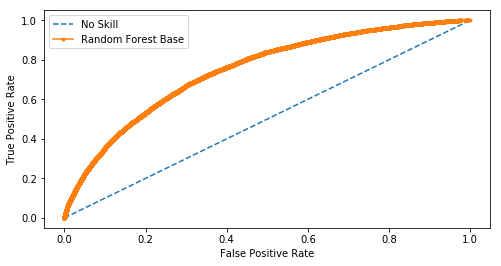

In [101]:
ROC_AUC_curve(model=rm_grid_search,model_name="Random Forest Base")

In [102]:
print("Training Accuracy Score:",accuracy_score(y_train,y_pred=rm_grid_search.predict(X_train)))
print("Testing Accuracy Score:",accuracy_score(y_test,y_pred=rm_grid_search.predict(X_test)))

Training Accuracy Score: 0.826927811871391
Testing Accuracy Score: 0.773310642356971


In [87]:
joblib.dump(rm_grid_search.best_estimator_,"random_forest_tuned.sav")

['random_forest_tuned.sav']

In [103]:
print("Testing Report")
print(classification_report(y_test,y_pred=rm_grid_search.predict(X_test)))

Testing Report
              precision    recall  f1-score   support

         0.0       0.95      0.79      0.87     84841
         1.0       0.19      0.54      0.28      7413

   micro avg       0.77      0.77      0.77     92254
   macro avg       0.57      0.67      0.57     92254
weighted avg       0.89      0.77      0.82     92254



Feature Importance from our Random Forest Model

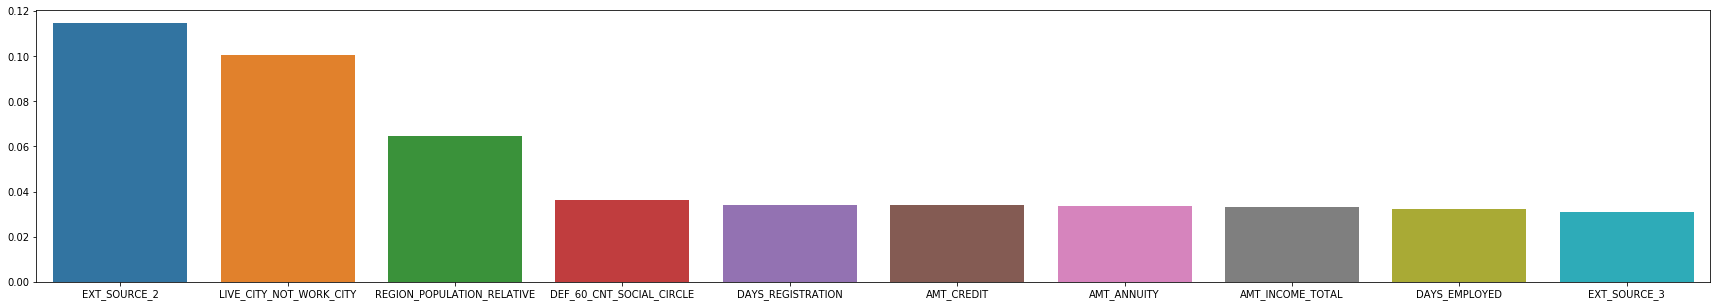

In [100]:
#if using saved model
plt.figure(figsize=(30,5))
feature_importance_rm=OrderedDict(sorted(zip(data.columns,rm_grid_search.feature_importances_),reverse=True,key=lambda x:x[1]))
sns.barplot(list(feature_importance_rm.keys())[:10],list(feature_importance_rm.values())[:10]);

In [ ]:
#if using after grid search directly
# plt.figure(figsize=(30,5))
# feature_importance_rm=OrderedDict(sorted(zip(data.columns,rm_grid_search.best_estimator_.feature_importances_),reverse=True,key=lambda x:x[1]))
# sns.barplot(list(feature_importance_rm.keys())[:10],list(feature_importance_rm.values())[:10]);